### This notebook generates the precipitation efficiency distribution for MCSs in the reanalysis-convective tracking data. First import libraries and constants.

In [1]:
import numpy as np
import scipy as sp
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import warnings
import numpy.ma as ma
import seaborn as sns
import scipy.optimize
from scipy.stats import pearsonr, zscore
from matplotlib import cm
from numpy import unravel_index

plt.rcParams.update({'font.size': 12})

warnings.filterwarnings(action='ignore')

from plotting_utilities import *
from thermodynamic_functions import *

In [2]:
g = 9.8 # gravitational acceleration [m s-2]
rho_air = 1.395 # density of air (kg m-3)
rho_water = 1000 #density of water (kg m-3)
eps = 0.01802/0.02897 # ratio of MW_water to MW_air

In [3]:
# array of years
years = np.arange( 1983, 2008 )

# create list of file names
file_years = file_concatenator(years)

# Are we only looking at tropical MCSs?
minlat_array = nc_open_compile(file_years,"min latitude")
print(np.nanmin(minlat_array))
maxlat_array = nc_open_compile(file_years,"max latitude")
print(np.nanmax(maxlat_array))
tropical_indx = np.argwhere( (minlat_array >= -30) & (maxlat_array <= 30) )[:,0]
print(tropical_indx.shape)

# applying same for MCS lifetime and morphology
lifetime_array = nc_open_compile(file_years,"lifetime")
lifetime_ERAI = negative_to_nan(lifetime_array)[tropical_indx]
maxrad_array = nc_open_compile(file_years,"maxrad")
maxrad_ERAI = negative_to_nan(maxrad_array)[tropical_indx]
minctt_array = nc_open_compile(file_years,"minctt")
minctt_ERAI = negative_to_nan(minctt_array)[tropical_indx]

# In reading in pmax, I do not yet filter for tropical lat/lon. That is done below.
pmax_array = nc_open_compile(file_years,"pmax")
pmax_ERAI = negative_to_nan(pmax_array)

-56.0
56.0
(695667,)


In [4]:
#pressure level values converted into double point precision
#factor of 100 converts hPa to Pa. we want to use SI units exclusively below.
plev_ERAI = np.double((xr.open_dataset(file_years[0])).pressure.data)*100

# calculate the saturation vapor mixing ratio, Curry & Webster (4.37)
# In this calculation, I do not yet filter for tropical lat/lon. That is done below.
temp_ERAI = nc_open_compile( file_years, "temperature", 'stack' )
qvsat_ERAI = eps * satVapP_liq(temp_ERAI) / ( plev_ERAI - satVapP_liq(temp_ERAI) )

In [5]:
# as in Singh et al. 2017 we calculate saturation deficit as the arithmetic mean
# between its values at 850, 700, and 550 hPa
qv_array = nc_open_compile( file_years, "qv", 'stack' )
qv_ERAI = negative_to_nan(qv_array)
qvpre_array = nc_open_compile( file_years, "qvpre", 'stack' )
qvpre_ERAI = negative_to_nan(qvpre_array)

i = np.argmin( np.abs(plev_ERAI - 85000) )
sd850_ERAI = (qvsat_ERAI[:,i] - qv_ERAI[:,i])*1000   # 1000 converts [kg kg-1] to [g kg-1]
sd850pre_ERAI = (qvsat_ERAI[:,i] - qvpre_ERAI[:,i])*1000
i = np.argmin( np.abs(plev_ERAI - 70000) )
sd700_ERAI = (qvsat_ERAI[:,i] - qv_ERAI[:,i])*1000
sd700pre_ERAI = (qvsat_ERAI[:,i] - qvpre_ERAI[:,i])*100
i = np.argmin( np.abs(plev_ERAI - 55000) )
sd550_ERAI = (qvsat_ERAI[:,i] - qv_ERAI[:,i])*1000
sd550pre_ERAI = (qvsat_ERAI[:,i] - qvpre_ERAI[:,i])*1000

sd_ERAI = (sd850_ERAI + sd700_ERAI + sd550_ERAI)/3
sdpre_ERAI = (sd850pre_ERAI + sd700pre_ERAI + sd550pre_ERAI)/3

### Precipitation efficiency from integrated condensation rate scaling

In [14]:
# Calculate the gradient with respect to pressure of the saturation vapor mixing ratio
p_ERAI = (xr.open_dataset(file_years[0])).pressure.data*100. # converting hPa -> Pa
dqvsat_dp_ERAI = np.gradient( qvsat_ERAI, p_ERAI, axis=1 )

# Multiply the gradient with respect to pressure by pressure velocity
omega_array = nc_open_compile(file_years,"omega",'stack')
ii = np.argwhere( np.all(omega_array < 0, axis=1) & (minlat_array >= -30) & (maxlat_array <= 30) )
print(len(ii))
omega_ERAI = omega_array[ii[:,0]]
#omega_ERAI = positive_to_nan(omega_array)[tropical_indx]
integrand = 100*omega_ERAI * dqvsat_dp_ERAI[ii[:,0]] / g

# Determine integration bounds on the basis of the cold-point tropopause
tempmean_ERAI = np.nanmean( temp_ERAI, axis=0 )

# Integrate the condensation rate over the pressures
cond_rate_ERAI = np.trapz( x=p_ERAI[:-1], y=-1.*integrand[:,:-1] )
print( np.nanmin(cond_rate_ERAI), np.nanmedian(cond_rate_ERAI), np.nanmean(cond_rate_ERAI), np.nanmax(cond_rate_ERAI) )
peff_ERAI = pmax_ERAI[ii[:,0]] / 3600 / cond_rate_ERAI
print( np.nanmin(peff_ERAI), np.nanmedian(peff_ERAI), np.nanmax(peff_ERAI) )

39382
-0.00034307661048427716 0.02440252914167579 0.02702560821009777 1.1008421073960388
-2.2184872679419456 0.06956274268330907 3.848225560481694


In [15]:
# Thermodynamic parameters - how strong is correlation with these?
# Do not filter for tropical lat/lon yet. That is done below.
t2m_array = nc_open_compile(file_years,"t2m")
t2m_ERAI = negative_to_nan(t2m_array)
dpt_array = nc_open_compile(file_years,"dpt")
dpt_ERAI = negative_to_nan(dpt_array)
sst_array = nc_open_compile(file_years,"sst")
sst_ERAI = negative_to_nan(sst_array)

In [16]:
# Storm morphology parameters - how strong is correlation with these?
# Do not filter for tropical lat/lon yet. That is done below.
rad_array = nc_open_compile(file_years,"rad")
rad_ERAI = negative_to_nan(rad_array)
ctt_array = nc_open_compile(file_years,"ctt")
ctt_ERAI = negative_to_nan(ctt_array)
maxrad_array = nc_open_compile(file_years,"maxrad")
maxrad_ERAI = negative_to_nan(maxrad_array)
minctt_array = nc_open_compile(file_years,"minctt")
minctt_ERAI = negative_to_nan(minctt_array)
lifetime_array = nc_open_compile(file_years,"lifetime")
lifetime_ERAI = negative_to_nan(lifetime_array)

In [17]:
# Integrated amounts of cloud condensate - how strong is correlation with these?
# Do not filter for tropical lat/lon yet. That is done below.
qi_array = nc_open_compile(file_years,"qi","stack")
qi_ERAI = negative_to_nan(qi_array)
IWP_ERAI = np.cumsum( rho_water*qi_ERAI, axis=1 )*1000 # [g m-2]
IWP_ERAI = IWP_ERAI[:,-1]
qc_array = nc_open_compile(file_years,"qc","stack")
qc_ERAI = negative_to_nan(qc_array)
LWP_ERAI = np.cumsum( rho_water*qc_ERAI, axis=1 )*1000 # [g m-2]
LWP_ERAI = LWP_ERAI[:,-1]

# CAPE and integrated mass flux - how strong is correlation with these?
cape_array = nc_open_compile(file_years,"cape")
cape_ERAI = negative_to_nan(cape_array)
capepre_array = nc_open_compile(file_years,"capepre")
capepre_ERAI = negative_to_nan(capepre_array)
capepre6_array = nc_open_compile(file_years,"capepre6")
capepre6_ERAI = negative_to_nan(capepre6_array)
omega_array = nc_open_compile(file_years,"omega","stack")
omega_ERAI = positive_to_nan(omega_array)
#omegaint_ERAI = np.cumsum( rho*w_ERAI, axis=1 )*1000 # [g m-2]
#print(omegaint_ERAI.shape)
#omegaint_ERAI = omegaint_ERAI[:,-1]
#print(omegaint_ERAI.shape)

In [18]:
print('Correlation of precip efficiency with storm morphology parameters')
for var in [ rad_ERAI, maxrad_ERAI, ctt_ERAI, minctt_ERAI, lifetime_ERAI ]:
    print( pe_cc( var, ii, peff_ERAI) )

print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
print('Correlation of precip efficiency with LWP versus IWP')
for var in [ LWP_ERAI, IWP_ERAI ]:
    print( pe_cc( var, ii, peff_ERAI) )
    
print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
print('Correlation of precip efficiency with various surface temperatures')
for var in [ t2m_ERAI, sst_ERAI, dpt_ERAI ]:
    print( pe_cc( var, ii, peff_ERAI) )

print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
print('Correlation of precip efficiency with CAPE')
for var in [ cape_ERAI, capepre_ERAI, capepre6_ERAI ]:
    print( pe_cc( np.sqrt(var), ii, peff_ERAI) )

print('Correlation of precip efficiency with SD')
for var in [ sd_ERAI, sdpre_ERAI ]:
    print( pe_cc( np.sqrt(var), ii, peff_ERAI) )

print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
#for j in np.arange( omega_ERAI.shape[1] ):
#    print( plev_ERAI[j] )
#    print( pe_cc( -1.*omega_ERAI[:,j] ,ii, peff_ERAI ) )

Correlation of precip efficiency with storm morphology parameters
(0.1481973398970044, 2.7284478113595437e-183)
(0.06687014396681763, 7.456971819824577e-38)
(0.05123668459474188, 3.7621584813909334e-24)
(-0.04087727428559208, 9.050217177964265e-16)
(0.043419378888829976, 3.0592968983113423e-17)
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Correlation of precip efficiency with LWP versus IWP
(0.0540682312198464, 7.003158031112211e-07)
(0.040215289593114475, 5.9598094910693346e-05)
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Correlation of precip efficiency with various surface temperatures
(-0.011148950677772999, 0.027859893566007286)
(0.01139614980444515, 0.0529231867422665)
(0.06323500925614536, 3.9948078900782984e-36)
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Correlation of precip efficiency with CAPE
(0.022554840206151637, 5.85141220363899e-05)
(0.014463410941476434, 0.013044418826081677)
(0.007754083426351408, 0.1709184326003561)
Correlation of precip efficiency with SD
(-0.110907397724238

In [19]:
print('Statistics of precipitation efficiency:')
print(np.percentile( peff_ERAI, 99 ))
print(np.nanmax( peff_ERAI ))
print(np.nanmedian( peff_ERAI))
print(np.nanmean( peff_ERAI))

Statistics of precipitation efficiency:
0.7117047008836426
3.848225560481694
0.06956274268330907
0.11745539077276183


In [20]:
lifetime_ERAI = lifetime_ERAI[ii[:,0]]
rad_ERAI = rad_ERAI[ii[:,0]]
minctt_ERAI = minctt_ERAI[ii[:,0]]

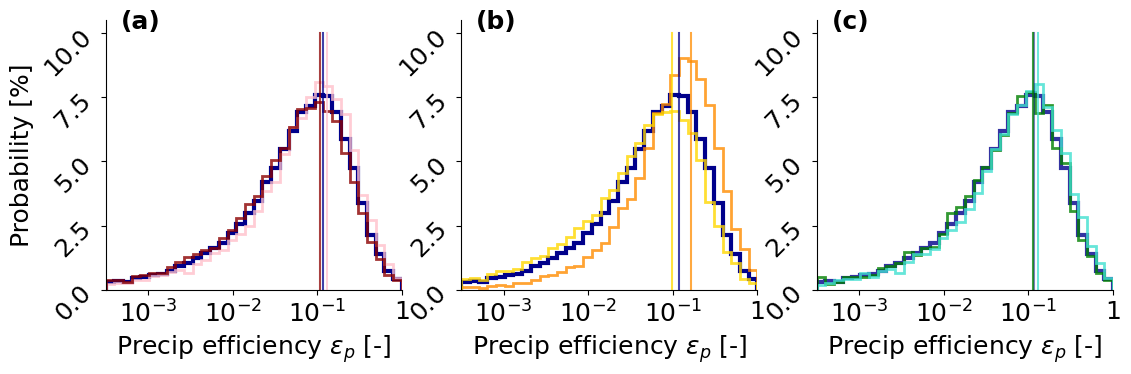

In [21]:
fs = 18
fig, ax = plt.subplots( 1, 3, figsize =(13, 3.5) )

wgts = np.ones_like( peff_ERAI )/float( len( peff_ERAI ) )*100
edges, h = np.histogram( peff_ERAI, weights=wgts, bins=np.logspace(-3.5,0,35) )

wgts2 = np.ones_like( peff_ERAI[rad_ERAI > 150] )/float( len( peff_ERAI[rad_ERAI > 150] ) )*100
edges2, h2 = np.histogram( peff_ERAI[rad_ERAI > 150], weights=wgts2, bins=np.logspace(-3.5,0,35) )

wgts3 = np.ones_like( peff_ERAI[rad_ERAI <= 110] )/float( len( peff_ERAI[rad_ERAI <= 110] ) )*100
edges3, h3 = np.histogram( peff_ERAI[rad_ERAI <= 110], weights=wgts3, bins=np.logspace(-3.5,0,35) )

wgts4 = np.ones_like( peff_ERAI[minctt_ERAI > 205] )/float( len( peff_ERAI[minctt_ERAI > 205] ) )*100
edges4, h4 = np.histogram( peff_ERAI[minctt_ERAI > 205], weights=wgts4, bins=np.logspace(-3.5,0,35) )

wgts5 = np.ones_like( peff_ERAI[minctt_ERAI <= 185] )/float( len( peff_ERAI[minctt_ERAI <= 185] ) )*100
edges5, h5 = np.histogram( peff_ERAI[minctt_ERAI <= 185], weights=wgts5, bins=np.logspace(-3.5,0,35) )

wgts6 = np.ones_like( peff_ERAI[lifetime_ERAI > 12] )/float( len( peff_ERAI[lifetime_ERAI > 12] ) )*100
edges6, h6 = np.histogram( peff_ERAI[lifetime_ERAI > 12], weights=wgts6, bins=np.logspace(-3.5,0,35) )

wgts7 = np.ones_like( peff_ERAI[lifetime_ERAI <= 3] )/float( len( peff_ERAI[lifetime_ERAI <= 3] ) )*100
edges7, h7 = np.histogram( peff_ERAI[lifetime_ERAI <= 3], weights=wgts7, bins=np.logspace(-3.5,0,35) )
    
ax[0].stairs( edges, h, edgecolor='darkblue', lw=3 )
ax[0].stairs( edges6, h6, edgecolor='pink', lw=2, alpha=0.8 )
ax[0].stairs( edges7, h7, edgecolor='darkred', lw=2, alpha=0.8 )
ax[0].plot( [np.nanmean(peff_ERAI), np.nanmean(peff_ERAI)], [0,10], color='darkblue', alpha=0.75 )
ax[0].plot( [np.nanmean(peff_ERAI[lifetime_ERAI>12]), np.nanmean(peff_ERAI[lifetime_ERAI>12])], [0,10], color='pink', alpha=0.75 )
ax[0].plot( [np.nanmean(peff_ERAI[lifetime_ERAI<=3]), np.nanmean(peff_ERAI[lifetime_ERAI<=3])], [0,10], color='darkred', alpha=0.75 )
ax[0].set_ylabel( 'Probability [%]', fontsize=fs )
ax[0].text( 0.05, 0.97, '(a)', weight='bold', fontsize=fs, transform=ax[0].transAxes )

ax[1].stairs( edges, h, edgecolor='darkblue', lw=3 )
ax[1].stairs( edges2, h2, edgecolor='darkorange', lw=2, alpha=0.8 )
ax[1].stairs( edges3, h3, edgecolor='gold', lw=2, alpha=0.8 )
ax[1].plot( [np.nanmean(peff_ERAI), np.nanmean(peff_ERAI)], [0,10], color='darkblue', alpha=0.75 )
ax[1].plot( [np.nanmean(peff_ERAI[rad_ERAI>150]), np.nanmean(peff_ERAI[rad_ERAI>150])], [0,10], color='darkorange', alpha=0.75 )
ax[1].plot( [np.nanmean(peff_ERAI[rad_ERAI<=110]), np.nanmean(peff_ERAI[rad_ERAI<=110])], [0,10], color='gold', alpha=0.75 )
ax[1].text( 0.05, 0.97, '(b)', weight='bold', fontsize=fs, transform=ax[1].transAxes )

ax[2].stairs( edges, h, edgecolor='darkblue', lw=3, alpha=0.8 )
ax[2].stairs( edges4, h4, edgecolor='green', lw=2, alpha=0.8 )
ax[2].stairs( edges5, h5, edgecolor='turquoise', lw=2, alpha=0.8 )
ax[2].plot( [np.nanmean(peff_ERAI), np.nanmean(peff_ERAI)], [0,10], color='darkblue', alpha=0.5 )
ax[2].plot( [np.nanmean(peff_ERAI[minctt_ERAI<=185]), np.nanmean(peff_ERAI[minctt_ERAI<=185])], [0,10], color='turquoise', alpha=0.75 )
ax[2].plot( [np.nanmean(peff_ERAI[minctt_ERAI>205]), np.nanmean(peff_ERAI[minctt_ERAI>205])], [0,10], color='green', alpha=0.75 )
ax[2].text( 0.05, 0.97, '(c)', weight='bold', fontsize=fs, transform=ax[2].transAxes )

for a in ax:
    a.set_xlabel( r'Precip efficiency $\varepsilon_p$ [-]', fontsize=fs )
    a.set_xscale( 'log' )
    a.spines['top'].set_visible(False)
    a.spines['right'].set_visible(False)
    a.tick_params( 'both', labelsize=18 )
    a.tick_params( 'y', rotation=45 )
    a.set_ylim([0,10.5])
    a.set_xlim([10**(-3.5),1])
    a.set_xticks([10**(-3), 10**(-2), 10**(-1), 1])
    a.set_xticklabels([r'10$^{-3}$', r'10$^{-2}$', r'10$^{-1}$', '1'])

#fig.savefig( '/groups/sylvia/JAS-MCS-rain/figures/precipeff-ERAI.pdf', bbox_inches='tight' )
plt.show()